In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#4 gene haplotype order and palette
firsta = ['S', 's']
seconda = ['A', 'a']
thirda = ['B', 'b']
fourtha = ['R', 'r']
hap_4gene_poss =[]

for a in firsta:
    for b in seconda:
        for c in thirda:
            for d in fourtha:
                hap_4gene_poss.append(a+b+c+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap_4gene_order = dict(zip(hap_4gene_poss, order))
 
num_cols = len(hap_4gene_poss)
cols = sns.color_palette("husl", num_cols)
col_4gene = dict(zip(hap_4gene_poss, cols))

In [3]:
#3 gene haplotype order and palette
firsta = ['S', 's']
seconda = ['A', 'a']
fourtha = ['R', 'r']
hap_3gene_poss =[]

for a in firsta:
    for b in seconda:
        for d in fourtha:
            hap_3gene_poss.append(a+b+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap_3gene_order = dict(zip(hap_3gene_poss, order))

num_cols = len(hap_3gene_poss)
cols = sns.color_palette("husl", num_cols)
col_3gene = dict(zip(hap_3gene_poss, cols))

In [4]:
#3 gene haplotype order and palette
firsta = ['C', 'c']
seconda = ['G', 'g']
hap_2gene_poss =[]

for a in firsta:
    for b in seconda:
        hap_2gene_poss.append(a+b)
                

num_cols = len(hap_2gene_poss)
cols = sns.color_palette("husl", num_cols)
col_2gene = dict(zip(hap_2gene_poss, cols))

In [5]:
#Import the data and flip into a multi index 
df = pd.read_csv('../Data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

#Now just look at RN data, and apply filters to identify cells with enough reads/amplicon
#RN_allele_plate is the key dataset going forward
RN_allele_plate = df.loc[df['Patient'].isin(['RN'])] #Make df with just RN data
RN_allele_plate = RN_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
RN_allele_plate['Cell_type'] = RN_allele_plate['Plate'].replace(plate_cell_dict)
RN_allele_plate['Plate_Well'] = RN_allele_plate['Plate'].astype(str) + '_' + RN_allele_plate['Well'].astype(str)

#Make list of cell types
celltype = sorted(RN_allele_plate['Cell_type'].drop_duplicates().to_list())
celltype

['CD34', 'CD34+/38-', 'Monocytes', 'NEs', 'nBCs']

In [6]:
#Apply filters to data and export as a list 
df = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
print('The columns (L-R) are;', list(df.columns))

#Find the cells/wells that contain >100 reads for the gDNA amplicons except TET2b and turn into a list
df1 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df1 = df1.iloc[:, [1,2,3]] 
df1 = df1.loc[(df1 >= 100).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
df1 = df1.stack()
df1['Plate'] = df1.index.get_level_values(0)  #These lines send indexes to columns
df1['Well'] = df1.index.get_level_values(1)
df1['Plate_Well'] = df1['Plate'].astype(str) + '_' + df1['Well'].astype(str)
gene3_100cut = df1['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene3_100cut_amps = df1.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 100 reads for 3 genes = ', len(gene3_100cut))

#Find the cells/wells that contain >15 reads for the gDNA amplicons  and turn into a list
df2 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df2 = df2.iloc[:, [1,2,3,5]] 
df2 = df2.loc[(df2 >= 15).all(axis=1)] #df2 contains just the rows with cells we want - use this to create a filter or key
df2 = df2.stack()
df2['Plate'] = df2.index.get_level_values(0)  #These lines send indexes to columns
df2['Well'] = df2.index.get_level_values(1)
df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
gene4_15cut = df2['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene4_15cut_amps = df2.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 15 reads for 4 genes = ', len(gene4_15cut))

#Find cells with 50 reads for RUNX1 cDNA or gDNA to compare methods
df3 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df3 = df3.iloc[:, [0,1]] 
df3 = df3.loc[(df3 >= 50).all(axis=1)]
df3 = df3.stack()
df3['Plate'] = df3.index.get_level_values(0)  #These lines send indexes to columns
df3['Well'] = df3.index.get_level_values(1)
df3['Plate_Well'] = df3['Plate'].astype(str) + '_' + df3['Well'].astype(str)
gene1_50cut = df3['Plate_Well'].drop_duplicates().to_list()
gene1_50cut_amps = df3.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 50 reads for RUNX1 cDNA ang gDNA = ', len(gene1_50cut))

#Find the cells/wells that contain >10 reads for the gDNA amplicons  and turn into a list
df4 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df4 = df4.iloc[:, [1,2,3,5]] 
df4 = df4.loc[(df4 >= 10).all(axis=1)] #df4 contains just the rows with cells we want - use this to create a filter or key
df4 = df4.stack()
df4['Plate'] = df4.index.get_level_values(0)  #These lines send indexes to columns
df4['Well'] = df4.index.get_level_values(1)
df4['Plate_Well'] = df4['Plate'].astype(str) + '_' + df4['Well'].astype(str)
gene4_10cut = df4['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene4_10cut_amps = df4.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 10 reads for 4 genes = ', len(gene4_10cut))

The columns (L-R) are; [('Reads', 'RN_RUNX1_c'), ('Reads', 'RN_RUNX1_g'), ('Reads', 'RN_SRSF2'), ('Reads', 'RN_TET2a'), ('Reads', 'RN_TET2b_c'), ('Reads', 'RN_TET2b_g')]
Cells with 100 reads for 3 genes =  794
Cells with 15 reads for 4 genes =  162
Cells with 50 reads for RUNX1 cDNA ang gDNA =  1645
Cells with 10 reads for 4 genes =  253


In [7]:
#Start with df1, gDNA amplicons except TET2b, filter list gene3_100cut
cutoff1 = 0.1 #Put haplotype cutoff here

plate1 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene3_100cut)]
plate1 = plate1[plate1['Amplicon'].isin(gene3_100cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate1 = plate1.iloc[:, 0:1].unstack(level = 3)
plate1['Total'] = plate1.iloc[: , 0] + plate1.iloc[: , 1]
plate1['Mut_freq'] = plate1.iloc[:, 0]/plate1['Total']

#Assign Wt or MT to each allele
plate1 = plate1.drop(columns = ['Reads', 'Total'])

conditions = [(plate1['Mut_freq'] <= cutoff1), (plate1['Mut_freq']) > cutoff1 ]
values = ['w', 'm']
plate1['Genotype'] = np.select(conditions, values)
plate1 = plate1.drop(columns = ['Mut_freq']).unstack(2)
plate1.columns = gene3_100cut_amps

plate1.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate1.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate1.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate1['Haplotype'] = plate1.iloc[:,1] + plate1.iloc[:,2] + plate1.iloc[:,0]
plate1['Cell_type'] = plate1.index.get_level_values(0)
plate1['Cell_type'] = plate1['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate1['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate1['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
c['order'] = c['hap']
c = c.replace({'order': hap_3gene_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_3gene, ax = ax[count]) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate1.loc[plate1['Cell_type'].isin([cell])].empty ==False:
    
        a = plate1.loc[plate1['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        a['order'] = a['hap']
        a = a.replace({'order': hap_3gene_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_3gene,  ax = ax[count]) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('3 gene, 100 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff1), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_3gen_100amp_cutoff_'+str(cutoff1)+ '.png',dpi=300)  
plt.close()

The number of haplotypes present is:  8


In [8]:
#Start with df2, gDNA amplicons gene4_15cut
cutoff2 = 0.2 #Put haplotype cutoff here

plate2 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene4_15cut)]
plate2 = plate2[plate2['Amplicon'].isin(gene4_15cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate2 = plate2.iloc[:, 0:1].unstack(level = 3)
plate2['Total'] = plate2.iloc[: , 0] + plate2.iloc[: , 1]
plate2['Mut_freq'] = plate2.iloc[:, 0]/plate2['Total']

#Assign Wt or MT to each allele
plate2 = plate2.drop(columns = ['Reads', 'Total'])

conditions = [(plate2['Mut_freq'] <= cutoff2), (plate2['Mut_freq']) > cutoff2 ]
values = ['w', 'm']
plate2['Genotype'] = np.select(conditions, values)
plate2 = plate2.drop(columns = ['Mut_freq']).unstack(2)
plate2.columns = gene4_15cut_amps

plate2.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate2.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate2.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate2.iloc[:,3].replace({'w':'B','m':'b' }, inplace = True)
plate2['Haplotype'] = plate2.iloc[:,1] + plate2.iloc[:,2] + plate2.iloc[:,3] + plate2.iloc[:,0]
plate2['Cell_type'] = plate2.index.get_level_values(0)
plate2['Cell_type'] = plate2['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate2['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 4 gene 15 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate2['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
c['order'] = c['hap']
c = c.replace({'order': hap_4gene_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_4gene, ax = ax[count]) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate2.loc[plate2['Cell_type'].isin([cell])].empty ==False:
    
        a = plate2.loc[plate2['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        a['order'] = a['hap']
        a = a.replace({'order': hap_4gene_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_4gene,  ax = ax[count]) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('4 gene, 15 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff2), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_4gen_15amp_cutoff_'+str(cutoff2)+ '.png',dpi=300)   
plt.close()

The number of haplotypes present is:  12


In [9]:
#Start with df4, gDNA amplicons gene4_10cut
cutoff4 = 0.1 #Put haplotype cutoff here

plate4 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene4_10cut)]
plate4 = plate4[plate4['Amplicon'].isin(gene4_10cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate4 = plate4.iloc[:, 0:1].unstack(level = 3)
plate4['Total'] = plate4.iloc[: , 0] + plate4.iloc[: , 1]
plate4['Mut_freq'] = plate4.iloc[:, 0]/plate4['Total']

#Assign Wt or MT to each allele
plate4 = plate4.drop(columns = ['Reads', 'Total'])

conditions = [(plate4['Mut_freq'] <= cutoff4), (plate4['Mut_freq']) > cutoff4 ]
values = ['w', 'm']
plate4['Genotype'] = np.select(conditions, values)
plate4 = plate4.drop(columns = ['Mut_freq']).unstack(2)
plate4.columns = gene4_10cut_amps

plate4.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate4.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate4.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate4.iloc[:,3].replace({'w':'B','m':'b' }, inplace = True)
plate4['Haplotype'] = plate4.iloc[:,1] + plate4.iloc[:,2] + plate4.iloc[:,3] + plate4.iloc[:,0]
plate4['Cell_type'] = plate4.index.get_level_values(0)
plate4['Cell_type'] = plate4['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate4['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 4 gene 10 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate4['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
c['order'] = c['hap']
c = c.replace({'order': hap_4gene_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_4gene, ax = ax[count]) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate4.loc[plate4['Cell_type'].isin([cell])].empty ==False:
    
        a = plate4.loc[plate4['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        a['order'] = a['hap']
        a = a.replace({'order': hap_4gene_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_4gene,  ax = ax[count]) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('4 gene, 10 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff4), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_4gen_10amp_cutoff_'+str(cutoff4)+ '.png',dpi=300)   
plt.close()


The number of haplotypes present is:  12


In [10]:
#Start with df3, gDNA amplicons gene1_50cut
cutoff3 = 0.1 #Put haplotype cutoff here

plate3 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene1_50cut)]
plate3 = plate3[plate3['Amplicon'].isin(gene1_50cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate3 = plate3.iloc[:, 0:1].unstack(level = 3)
plate3['Total'] = plate3.iloc[: , 0] + plate3.iloc[: , 1]
plate3['Mut_freq'] = plate3.iloc[:, 0]/plate3['Total']

#Assign Wt or MT to each allele
plate3 = plate3.drop(columns = ['Reads', 'Total'])

conditions = [(plate3['Mut_freq'] <= cutoff3), (plate3['Mut_freq']) > cutoff3 ]
values = ['w', 'm']
plate3['Genotype'] = np.select(conditions, values)
plate3 = plate3.drop(columns = ['Mut_freq']).unstack(2)
plate3.columns = gene1_50cut_amps

plate3.iloc[:,0].replace({'w':'C','m':'c' }, inplace = True)
plate3.iloc[:,1].replace({'w':'G','m':'g' }, inplace = True)

plate3['Haplotype'] = plate3.iloc[:,0] + plate3.iloc[:,1]
plate3['Cell_type'] = plate3.index.get_level_values(0)
plate3['Cell_type'] = plate3['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate3['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate3['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_2gene, ax = ax[0]) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate3.loc[plate3['Cell_type'].isin([cell])].empty ==False:
    
        a = plate3.loc[plate3['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_2gene, ax = ax[count]) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('1 gene, 50 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff3), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_1gen_50amp_cutoff_'+str(cutoff3)+ '.png',dpi=300)   
plt.close()

The number of haplotypes present is:  4


In [11]:
#Create frequency tables for each haplotype for each plate - need to include 0 frequency for haplotypes that weren't observed
#List of possible haplotypes already generated hap_4gene_poss and hap_3gene_poss
total1 = plate1['Haplotype'].value_counts().sum()
counts1 = dict(plate1['Haplotype'].value_counts()/total1)
print('Plate1', cutoff1, len(counts1))

for hap in hap_3gene_poss:
    if hap in counts1.keys():
        continue
    else:
        counts1[hap] = 0

total2 = plate2['Haplotype'].value_counts().sum()
counts2 = dict(plate2['Haplotype'].value_counts()/total2)

for hap in hap_4gene_poss:
    if hap in counts2.keys():
        continue
    else:
        counts2[hap] = 0

print('Plate2', cutoff2, len(counts2))

total3 = plate3['Haplotype'].value_counts().sum()
counts3 = dict(plate3['Haplotype'].value_counts()/total3)
print('Plate3',cutoff3, len(counts3))

total4 = plate4['Haplotype'].value_counts().sum()
counts4 = dict(plate1['Haplotype'].value_counts()/total4)

for hap in hap_3gene_poss:
    if hap in counts4.keys():
        continue
    else:
        counts4[hap] = 0
        
print('Plate4', cutoff4, len(counts4))


Plate1 0.1 8
Plate2 0.2 16
Plate3 0.1 4
Plate4 0.1 8


In [12]:
trajectory4 = ['SABR', 'sABR', 'saBR', 'sabR', 'sabr']
trajectory3 = ['SAR', 'sAR', 'saR', 'sar']

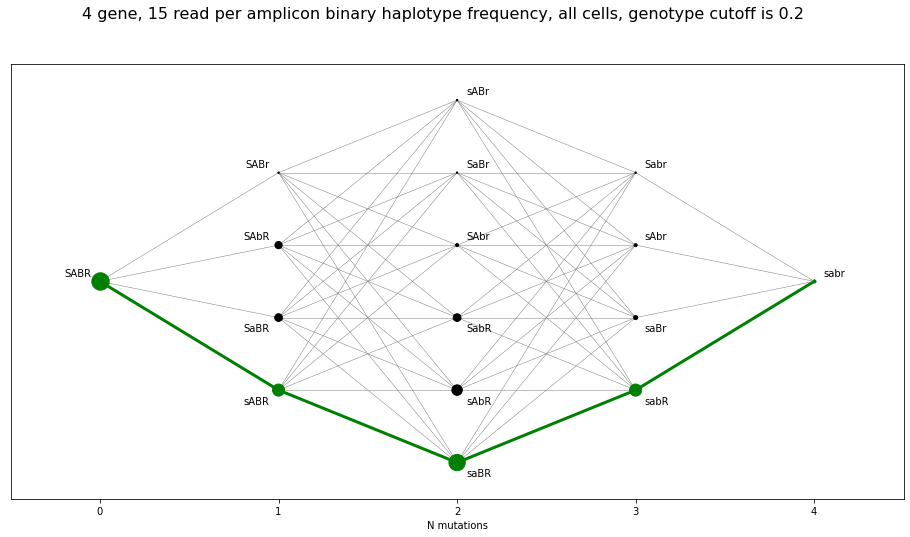

In [13]:
#Four haplotype graph
haplo_freqs = pd.DataFrame.from_dict(counts2, orient='index', columns = ['freq'])  #put the desired freq list here
cut = cutoff2 #put cutoff variable for data here

def count_muts(x):
    return (np.array(['S', 'A', 'B', 'R']) != list(x)).sum()

haplo_freqs['n_muts'] = [count_muts(x) for x in haplo_freqs['freq'].index] #Count of how many genes are mutated in that haplotype

hmax = haplo_freqs['freq'].max()
fig, ax = plt.subplots(figsize = (16,8))
for nmut in range(5):
    hap = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut]
    nh = len(hap)
    ys = np.arange(nh) - 0.5 * (nh - 1)
    xs = [nmut] * len(ys)

    # Sizes
    #s = 2 + 150 * np.sqrt(hap['freq'].values / hmax)
    s = 2 + 300 * (hap['freq'].values / hmax)
    
    # Color
    c = ['green' if x in trajectory4 else 'k' for x in hap.index]

    ax.scatter(xs, ys, s=s, c=c)

    for hname, y in zip(hap.index, ys):
        if (y >= 0) & (nmut < 1.5):
            ax.text(nmut - 0.05, y + 0.05, hname, ha='right',
va='bottom')
        elif y >= 0:
            ax.text(nmut + 0.05, y + 0.05, hname, ha='left',
va='bottom')
        elif nmut < 1.5:
            ax.text(nmut - 0.05, y - 0.08, hname, ha='right', va='top')
        else:
            ax.text(nmut + 0.05, y - 0.08, hname, ha='left', va='top')

    if nmut != 4:
        hap2 = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut + 1]
        nh2 = len(hap2)
        ys2 = np.arange(nh2) - 0.5 * (nh2 - 1)
        for hname, y in zip(hap.index, ys):
            for hname2, y2 in zip(hap2.index, ys2):
                if (trajectory4[nmut] == hname) and (trajectory4[nmut 
+ 1] == hname2):
                    lw = 3
                    color = 'green'
                else:
                    lw = 0.5
                    color = 'grey'
                ax.plot([nmut, nmut+1], [y, y2], color=color, lw=lw, zorder=0)

ax.set_xlim(-0.5, 4.5)
ax.set_xticks(np.arange(5))
ax.set_xlabel('N mutations')
ax.set_ylim(-3, 3)
ax.set_yticks([])
#fig.tight_layout()

fig.suptitle('4 gene, 15 read per amplicon binary haplotype frequency, all cells, genotype cutoff is ' + str(cutoff2), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_4gen_15amp_cutoff_trajectory'+str(cutoff2)+ '.png',dpi=300)

plt.ion(); plt.show()
#How to only show possible trajectories?

In [14]:
counts2

{'SABR': 0.25925925925925924,
 'saBR': 0.22839506172839505,
 'sABR': 0.12345679012345678,
 'sabR': 0.12345679012345678,
 'sAbR': 0.09259259259259259,
 'SaBR': 0.04938271604938271,
 'SabR': 0.04938271604938271,
 'SAbR': 0.043209876543209874,
 'saBr': 0.012345679012345678,
 'SAbr': 0.006172839506172839,
 'sabr': 0.006172839506172839,
 'sAbr': 0.006172839506172839,
 'SABr': 0,
 'SaBr': 0,
 'Sabr': 0,
 'sABr': 0}

In [15]:
#violin plots to go with the barplots (showing frequency)

In [21]:
a = RN_allele_plate.loc[RN_allele_plate['Plate'].isin(['AS-201'])]
b = a['Well'].drop_duplicates().to_list()
b
#a.loc[a['Well']]

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A16',
 'A17',
 'A18',
 'A19',
 'A20',
 'A21',
 'A22',
 'A23',
 'A24',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'B13',
 'B14',
 'B15',
 'B16',
 'B17',
 'B18',
 'B19',
 'B20',
 'B21',
 'B22',
 'B23',
 'B24',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D16',
 'D17',
 'D18',
 'D19',
 'D20',
 'D21',
 'D22',
 'D23',
 'D24',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E15',
 'E16',
 'E17',
 'E18',
 'E19',
 'E20',
 'E21',
 'E22',
 'E23',
 'E24',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12'

In [22]:
plate2

RN_RUNX1_g RN_SRSF2 RN_TET2a RN_TET2b_g Haplotype Cell_type
AS-195 B4           R        s        a          B      saBR       NEs
       B9           R        s        A          B      sABR       NEs
       B12          R        s        A          b      sAbR       NEs
       B18          R        s        A          b      sAbR       NEs
       C9           R        s        A          B      sABR       NEs
...               ...      ...      ...        ...       ...       ...
AS-194 O18          R        S        A          B      SABR      nBCs
       O20          R        S        A          B      SABR      nBCs
       O22          R        S        A          B      SABR      nBCs
AS-197 K21          R        s        a          B      saBR      CD34
       L2           R        s        a          b      sabR      CD34

[162 rows x 6 columns]